In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import Imputer, LabelEncoder, OneHotEncoder
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score, train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost
from xgboost.sklearn import XGBClassifier
import os
import re
import copy
import warnings
warnings.filterwarnings("ignore")
%cd /Users/maegbug/competetion_data/titanic/

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


/Users/maegbug/competetion_data/titanic


# The Goal and Procedures

- The goal of this project is achieving 80% "Accuracy" of the testing target
- The procedure of this project will be like following
    <ul> 0. Data Explanation & Loading </ul>
    <ul> 1. Exploring Data Analysis(EDA) </ul>
    <ul> 2. Data Cleasing </ul>
    <ul> 3. Feautre Engineering </ul>
    <ul> 4. Model Training </ul>
    <ul> 5. Project Delivery & Summary </ul>

### Data Dictionary

<tbody>
<tr><th><b>Variable</b></th><th><b>Definition</b></th><th><b>Key</b></th></tr>
<tr>
<td>survival</td>
<td>Survival</td>
<td>0 = No, 1 = Yes</td>
</tr>
<tr>
<td>pclass</td>
<td>Ticket class</td>
<td>1 = 1st, 2 = 2nd, 3 = 3rd</td>
</tr>
<tr>
<td>sex</td>
<td>Sex</td>
<td></td>
</tr>
<tr>
<td>Age</td>
<td>Age in years</td>
<td></td>
</tr>
<tr>
<td>sibsp</td>
<td># of siblings / spouses aboard the Titanic</td>
<td></td>
</tr>
<tr>
<td>parch</td>
<td># of parents / children aboard the Titanic</td>
<td></td>
</tr>
<tr>
<td>ticket</td>
<td>Ticket number</td>
<td></td>
</tr>
<tr>
<td>fare</td>
<td>Passenger fare</td>
<td></td>
</tr>
<tr>
<td>cabin</td>
<td>Cabin number</td>
<td></td>
</tr>
<tr>
<td>embarked</td>
<td>Port of Embarkation</td>
<td>C = Cherbourg, Q = Queenstown, S = Southampton</td>
</tr>
</tbody>

- pclass: A proxy for socio-economic status (SES)
<ol> 1st = Upper
<br>2nd = Middle
<br>3rd = Lower</ol>
<br>
- age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5
<br>
- sibsp: The dataset defines family relations in this way...
<ol>Sibling = brother, sister, stepbrother, stepsister
<br>Spouse = husband, wife (mistresses and fiancés were ignored)</ol>
<br>
- parch: The dataset defines family relations in this way...
<ol>Parent = mother, father
<br>Child = daughter, son, stepdaughter, stepson
<br>Some children travelled only with a nanny, therefore parch=0 for them.</ol>

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
train.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


In [4]:
test.tail()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S
417,1309,3,"Peter, Master. Michael J",male,NaN,1,1,2668,22.3583,NaN,C


## Dist of Survival

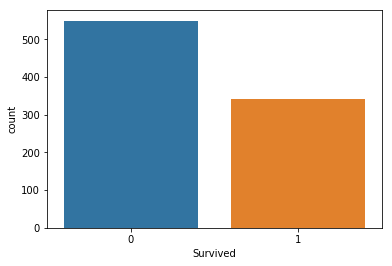

The ratio between survived and NOT suvived is 0.38 and 0.62


In [5]:
sns.countplot(train.Survived)
plt.show()
print("The ratio between survived and NOT suvived is %s and %s" % 
      (round(train.Survived.sum() / len(train.Survived),2), 1-round(train.Survived.sum() / len(train.Survived),2)))

# Missing Values & Data types Summary

In [6]:
def missing_value_summary(df):
    missing_values = df.isnull().sum()
    missing_values_per = round(100 * missing_values / len(df), 1)
    missing_value_table = pd.concat([missing_values, missing_values_per], axis = 1)
    columns = {0: "Missing values", 1: "% of Missing values"}
    missing_value_table_columns = missing_value_table.rename(columns = columns)
    missing_value_table_columns = missing_value_table_columns[missing_value_table_columns.iloc[:,1] != 0].sort_values(
        "% of Missing values", ascending = False)
    return missing_value_table_columns

In [7]:
missing_value_summary(train)

,Missing values,% of Missing values
Cabin,687,77.1
Age,177,19.9
Embarked,2,0.2


In [8]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [9]:
train.dtypes.value_counts()

int64      5
object     5
float64    2
dtype: int64

In [10]:
# # of unique values on categorial feature
train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

Name        891
Sex           2
Ticket      681
Cabin       147
Embarked      3
dtype: int64

# EDA

In [11]:
def value_eda(df, tables):
    for i, j in enumerate(tables):
        plt.figure(figsize = (10,20))
        plt.subplot(len(tables), 2, i + 1)
        sns.countplot(df[j])
        plt.title("Dist of Feature %s" % (j))
        plt.show()
        plt.figure(figsize = (10,15))
        plt.subplot(len(tables), 2, i + 1)
        sns.barplot(x = j, y = 'Survived', data = train)
        plt.title("Ratio of Survived")
        plt.show()
        values = df[j].value_counts()
        value_sum = values.sum()
        ratio_df = pd.DataFrame(values)
        ratio_df['ratio'] = round(ratio_df[j] / value_sum, 2) * 100
        print(ratio_df[:10])

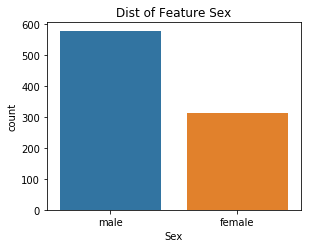

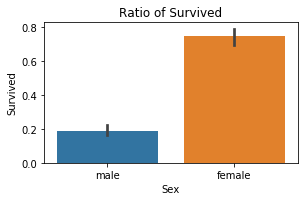

        Sex  ratio
male    577   65.0
female  314   35.0


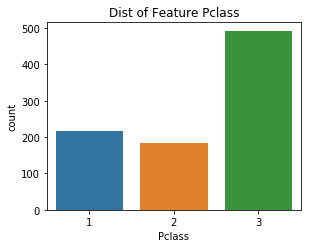

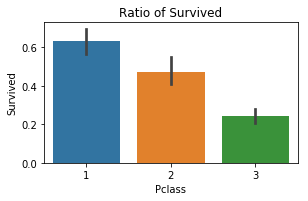

   Pclass  ratio
3     491   55.0
1     216   24.0
2     184   21.0


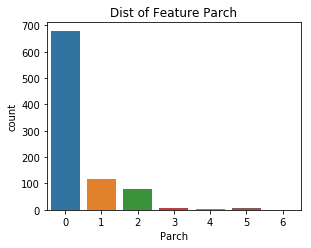

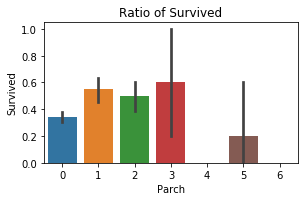

   Parch  ratio
0    678   76.0
1    118   13.0
2     80    9.0
5      5    1.0
3      5    1.0
4      4    0.0
6      1    0.0


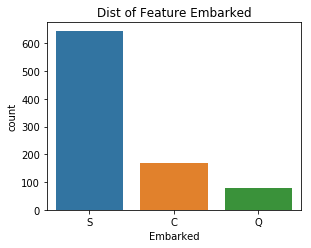

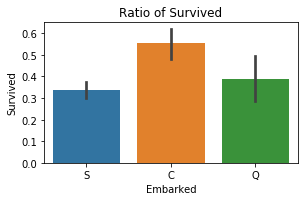

   Embarked  ratio
S       644   72.0
C       168   19.0
Q        77    9.0


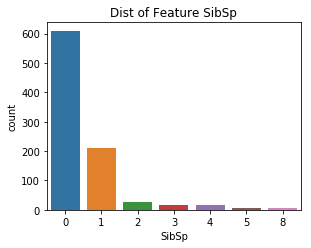

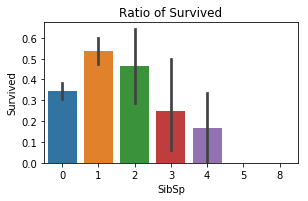

   SibSp  ratio
0    608   68.0
1    209   23.0
2     28    3.0
4     18    2.0
3     16    2.0
8      7    1.0
5      5    1.0


In [12]:
columns = ["Sex", "Pclass", "Parch", "Embarked", "SibSp"]
value_eda(train, tables = columns)

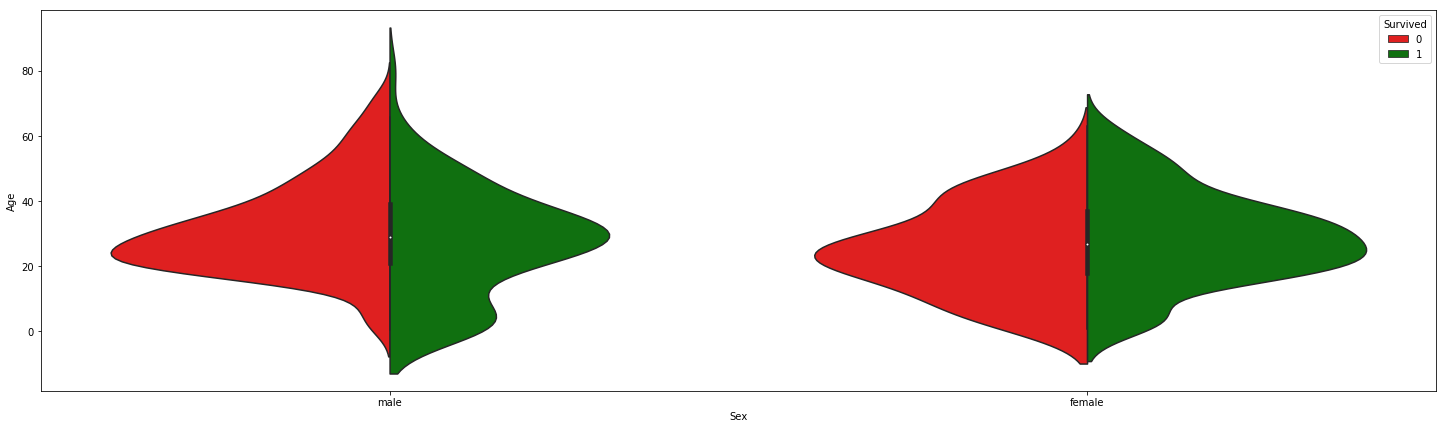

In [13]:
fig = plt.figure(figsize=(25, 7))
sns.violinplot(x='Sex', y='Age', 
               hue='Survived', data=train, 
               split=True,
               palette={0: "r", 1: "g"}
              );

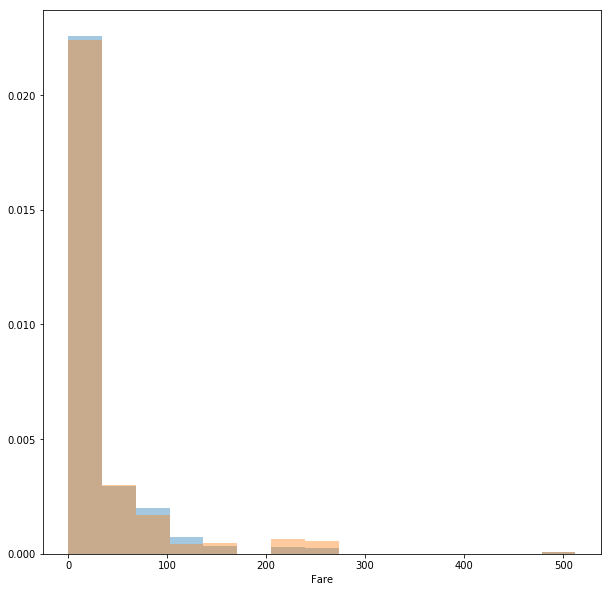

In [14]:
plt.figure(figsize=(10,10))
sns.distplot(train.Fare, kde = False, bins = 15, norm_hist=True)
sns.distplot(test.Fare[test.Fare.notnull()], kde = False, bins = 15, norm_hist=True)
plt.show()

(-0.005, 0.05612313887175992)

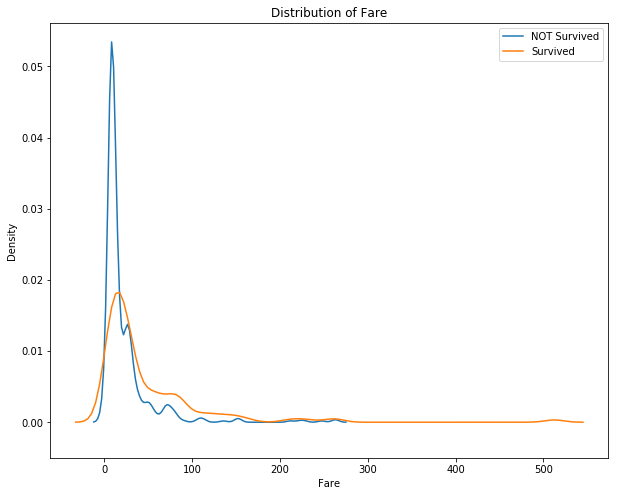

In [15]:
plt.figure(figsize=(10,8))
sns.kdeplot(train.Fare[train.Survived == 0], label = "NOT Survived")
sns.kdeplot(train.Fare[train.Survived == 1], label = "Survived")
plt.xlabel("Fare"); plt.ylabel("Density"); plt.title("Distribution of Fare"); plt.ylim(-0.005,)

<li> Decide to make new features by name of a ticket 
<li> Ticket's name which consist of number will be separated by their length </li>
<li> Ticket's name which consist of string will be separated by their name </li></li>

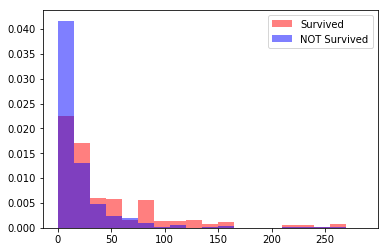

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.figure(figsize=(10,10))
ax.hist(train["Fare"][train["Survived"] == 1], bins=range(0,300,15), color='r',
        density=True, label='Survived', alpha = 0.5, lw = 5, ls = 'dashed')
ax.legend()
ax.hist(train["Fare"][train["Survived"] == 0], bins=range(0,300,15), color='b',
        density=True, label='NOT Survived', alpha = 0.5, lw = 5, ls = 'dotted')
ax.legend()
plt.show()

- as you can find in the pmf fare can be featured out where is it less than 20 or more

In [17]:
train.loc[train.Fare >= 15, 'Fare_more_than_15'] = 1
train.loc[train.Fare <15, 'Fare_more_than_15'] = 0
test.loc[test.Fare >= 15, 'Fare_more_than_15'] = 1
test.loc[test.Fare < 15, 'Fare_more_than_15'] = 0

In [18]:
train["Family_size"] = train["SibSp"] + train["Parch"]
test["Family_size"] = test["SibSp"] + test["Parch"]

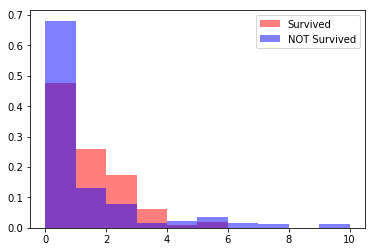

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.figure(figsize=(10,10))
ax.hist(train["Family_size"][train["Survived"] == 1], color='r', bins = 6,
        density=True, label='Survived', alpha = 0.5, lw = 5, ls = 'dashed')
ax.legend()
ax.hist(train["Family_size"][train["Survived"] == 0], color='b',bins = 10,
        density=True, label='NOT Survived', alpha = 0.5, lw = 5, ls = 'dotted')
ax.legend()
plt.show()

- from family_size dist you can saperate it as 2 part the 0 and other

In [20]:
train.loc[train.Family_size == 0, 'Family_size_0'] = 1
train.loc[train.Family_size > 0, 'Family_size_0'] = 0
test.loc[test.Family_size == 0, 'Family_size_0'] = 1
test.loc[test.Family_size > 0, 'Family_size_0'] = 0

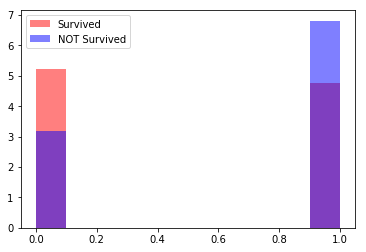

In [21]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.figure(figsize=(10,10))
ax.hist(train["Family_size_0"][train["Survived"] == 1], color='r',
        density=True, label='Survived', alpha = 0.5, lw = 5, ls = 'dashed')
ax.legend()
ax.hist(train["Family_size_0"][train["Survived"] == 0], color='b',
        density=True, label='NOT Survived', alpha = 0.5, lw = 5, ls = 'dotted')
ax.legend()
plt.show()

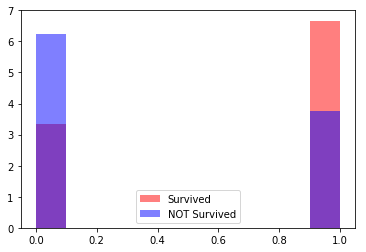

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.figure(figsize=(10,10))
ax.hist(train["Fare_more_than_15"][train["Survived"] == 1], color='r',
        density=True, label='Survived', alpha = 0.5, lw = 5, ls = 'dashed')
ax.legend()
ax.hist(train["Fare_more_than_15"][train["Survived"] == 0], color='b',
        density=True, label='NOT Survived', alpha = 0.5, lw = 5, ls = 'dotted')
ax.legend()
plt.show()

In [23]:
# # Making a column for ticket name
# ticket_name = re.compile(r"^.+(?=\s)")
# ticket_number = re.compile(r"^\d+")
# new_cat_list = []
# concat_data = pd.concat([train, test])
# for i in concat_data.Ticket:
#     compiled = re.match(ticket_name, i)
#     if not isinstance(compiled, type(None)):
#         new_cat_list.append(compiled.group())
#     elif not isinstance(re.match(ticket_number, i), type(None)):
#         new_cat_list.append(str(len(re.match(ticket_number, i).group())) + re.match(ticket_number, i).group()[0])
#     else:
#         new_cat_list.append('etc')
# concat_data['Ticket_name'] = new_cat_list
# concat_data.Ticket_name.value_counts()

- It seems like ticket names have some patterns

In [24]:
concat_data = pd.concat([train, test])
ticket_more_than_3 = train.Ticket.value_counts() > 2
ticket_index = ticket_more_than_3[ticket_more_than_3 == True].index

In [25]:
concat_data.tail()

,Age,Cabin,Embarked,Family_size,Family_size_0,Fare,Fare_more_than_15,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
413,NaN,NaN,S,0,1.0,8.0500,0.0,"Spector, Mr. Woolf",0,1305,3,male,0,NaN,A.5. 3236
414,39.0,C105,C,0,1.0,108.9000,1.0,"Oliva y Ocana, Dona. Fermina",0,1306,1,female,0,NaN,PC 17758
415,38.5,NaN,S,0,1.0,7.2500,0.0,"Saether, Mr. Simon Sivertsen",0,1307,3,male,0,NaN,SOTON/O.Q. 3101262
416,NaN,NaN,S,0,1.0,8.0500,0.0,"Ware, Mr. Frederick",0,1308,3,male,0,NaN,359309
417,NaN,NaN,C,2,0.0,22.3583,1.0,"Peter, Master. Michael J",1,1309,3,male,1,NaN,2668


In [26]:
# making new feature of married men and women
concat_data.loc[concat_data.Name.str.contains("Miss"), 'Is_Miss'] = 1
concat_data.loc[concat_data.Name.str.contains(r"^((?!Miss).)*$"), 'Is_Miss'] = 0
concat_data.loc[concat_data.Name.str.contains("Mr\."), 'Is_Mr'] = 1
concat_data.loc[concat_data.Name.str.contains(r"^((?!Mr\.).)*$"), 'Is_Mr'] = 0
concat_data.loc[concat_data.Name.str.contains("Mrs"), 'Is_Mrs'] = 1
concat_data.loc[concat_data.Name.str.contains(r"^((?!Mrs).)*$"), 'Is_Mrs'] = 0
concat_data.loc[concat_data.Name.str.contains("\sDr\."), 'Is_Dr'] = 1
concat_data.loc[concat_data.Name.str.contains(r"^((?!\sDr\.).)*$"), 'Is_Dr'] = 0
concat_data.loc[concat_data.Name.str.contains("Master"), 'Is_Master'] = 1
concat_data.loc[concat_data.Name.str.contains(r"^((?!Master).)*$"), 'Is_Master'] = 0

In [27]:
title_list = ["Is_Miss", "Is_Mr", "Is_Mrs", "Is_Dr", "Is_Master"]
for i in title_list:
    concat_data.loc[concat_data[i] == 1, "title"] = i

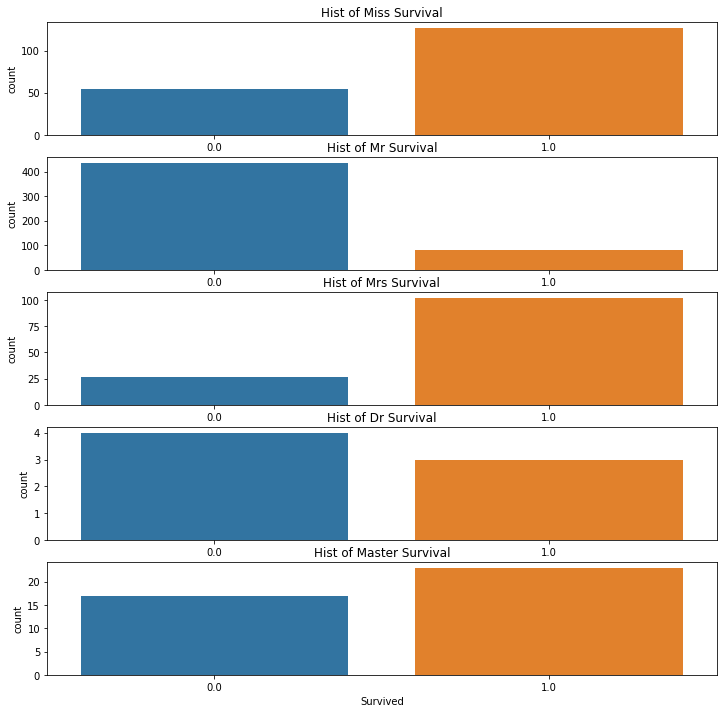

In [28]:
# Distribution of Survival by Their name
train = concat_data[:891]
plt.figure(figsize=(12,12))
plt.subplot(5,1,1)
sns.countplot(train[train['Is_Miss'] == True].Survived)
plt.title("Hist of Miss Survival")
plt.subplot(5,1,2)
sns.countplot(train[train['Is_Mr'] == True].Survived)
plt.title("Hist of Mr Survival")
plt.subplot(5,1,3)
sns.countplot(train[train['Is_Mrs'] == True].Survived)
plt.title("Hist of Mrs Survival")
plt.subplot(5,1,4)
sns.countplot(train[train['Is_Dr'] == True].Survived)
plt.title("Hist of Dr Survival")
plt.subplot(5,1,5)
sns.countplot(train[train['Is_Master'] == True].Survived)
plt.title("Hist of Master Survival")
plt.show()

In [29]:
# ticket_more_than_1 = concat_data["Ticket"].value_counts()
# ticket_index = ticket_more_than_1[ticket_more_than_1 > 1].index
# concat_data["team_survival_rate"] = np.tile(np.nan, len(concat_data))
# for i in ticket_index:
#     if len(concat_data[concat_data.Ticket == i]) > 1:
#         length = len(concat_data[concat_data.Ticket == i])
#         for k in range(length):
#             j = concat_data[concat_data.Ticket == i].iloc[k]
#             try:
#                 if j.Survived == 0:
#                     j['team_survival_rate'] = (train[train.Ticket == i]['Survived'].sum() - 1) / (len(train[train.Ticket == i]['Survived']) - 1)
#                 else:
#                     j['team_survival_rate'] = (train[train.Ticket == i]['Survived'].sum()) / (len(train[train.Ticket == i]['Survived']) - 1)
#             except ZeroDivisionError as err:
#                 j['team_survival_rate'] = 0.5
#             except:
#                 j['team_survival_rate'] = train[train.Ticket == i]['Survived'].sum() / ticket_more_than_1[i]
#             concat_data.loc[concat_data.PassengerId == j.PassengerId, 'team_survival_rate'] = j['team_survival_rate']
# concat_data['team_survival_rate'].fillna(0.5, inplace = True)

In [30]:
# concat_data['team_survival_rate'].fillna(0.5, inplace = True)
# concat_data.loc[concat_data['team_survival_rate'] < 0, 'team_survival_rate'] = 0.5
# concat_data.loc[concat_data['team_survival_rate'] == np.inf, 'team_survival_rate'] = 0.5
# concat_data.loc[concat_data['team_survival_rate'] > 1, 'team_survival_rate' ] = 1

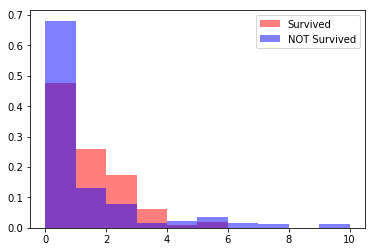

In [31]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.figure(figsize=(10,10))
ax.hist(train["Family_size"][train["Survived"] == 1], color='r', bins=6,
        density=True, label='Survived', alpha = 0.5, lw = 5, ls = 'dashed')
ax.legend()
ax.hist(train["Family_size"][train["Survived"] == 0], color='b', bins=10,
        density=True, label='NOT Survived', alpha = 0.5, lw = 5, ls = 'dotted')
ax.legend()
plt.show()

- creating fellow's survival_rate'

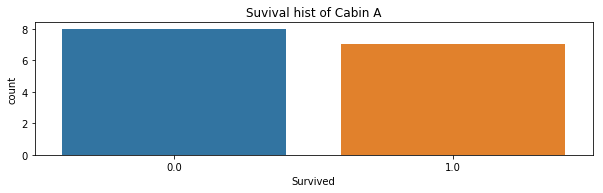

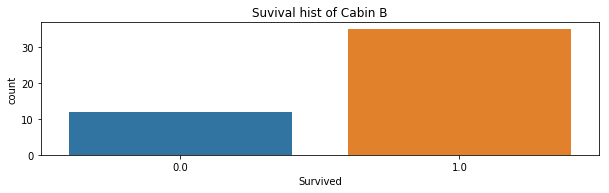

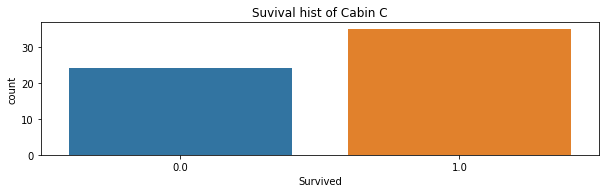

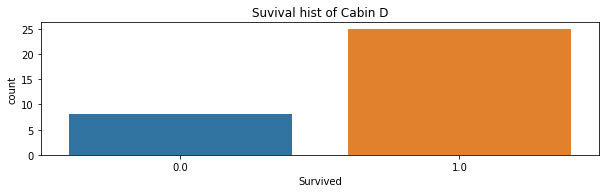

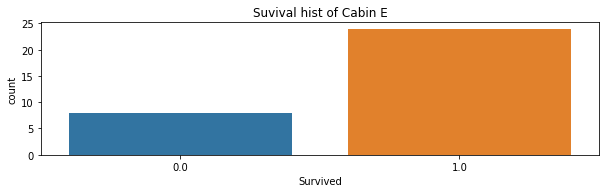

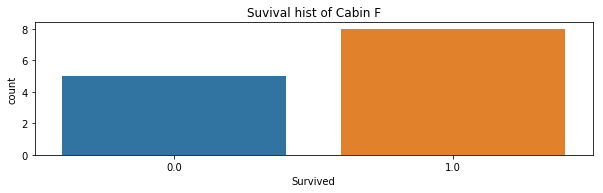

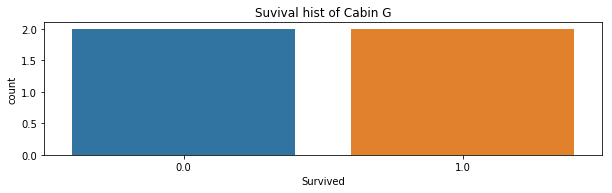

In [32]:
# Distribution of Survival by their Cabin category

cabin_list = "ABCDEFG"
for i in range(len(cabin_list)):
    plt.figure(figsize=(10,20))
    plt.subplot(len(cabin_list), 1, i+1)
    sns.countplot(concat_data[concat_data.Cabin.str.contains("^" + cabin_list[i]) == True].Survived)
    plt.title("Suvival hist of Cabin %s" % cabin_list[i])
    plt.show()

In [33]:
concat_data

,Age,Cabin,Embarked,Family_size,Family_size_0,Fare,Fare_more_than_15,Name,Parch,PassengerId,...,Sex,SibSp,Survived,Ticket,Is_Miss,Is_Mr,Is_Mrs,Is_Dr,Is_Master,title
0,22.0,NaN,S,1,0.0,7.2500,0.0,"Braund, Mr. Owen Harris",0,1,...,male,1,0.0,A/5 21171,0.0,1.0,0.0,0.0,0.0,Is_Mr
1,38.0,C85,C,1,0.0,71.2833,1.0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,...,female,1,1.0,PC 17599,0.0,0.0,1.0,0.0,0.0,Is_Mrs
2,26.0,NaN,S,0,1.0,7.9250,0.0,"Heikkinen, Miss. Laina",0,3,...,female,0,1.0,STON/O2. 3101282,1.0,0.0,0.0,0.0,0.0,Is_Miss
3,35.0,C123,S,1,0.0,53.1000,1.0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,...,female,1,1.0,113803,0.0,0.0,1.0,0.0,0.0,Is_Mrs
4,35.0,NaN,S,0,1.0,8.0500,0.0,"Allen, Mr. William Henry",0,5,...,male,0,0.0,373450,0.0,1.0,0.0,0.0,0.0,Is_Mr
5,NaN,NaN,Q,0,1.0,8.4583,0.0,"Moran, Mr. James",0,6,...,male,0,0.0,330877,0.0,1.0,0.0,0.0,0.0,Is_Mr
6,54.0,E46,S,0,1.0,51.8625,1.0,"McCarthy, Mr. Timothy J",0,7,...,male,0,0.0,17463,0.0,1.0,0.0,0.0,0.0,Is_Mr
7,2.0,NaN,S,4,0.0,21.0750,1.0,"Palsson, Master. Gosta Leonard",1,8,...,male,3,0.0,349909,0.0,0.0,0.0,0.0,1.0,Is_Master
8,27.0,NaN,S,2,0.0,11.1333,0.0,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",2,9,...,female,0,1.0,347742,0.0,0.0,1.0,0.0,0.0,Is_Mrs
9,14.0,NaN,C,1,0.0,30.0708,1.0,"Nasser, Mrs. Nicholas (Adele Achem)",0,10,...,female,1,1.0,237736,0.0,0.0,1.0,0.0,0.0,Is_Mrs


In [34]:
concat_data["Cabin"].fillna(0,inplace = True)
concat_data.loc[concat_data.Cabin.str.contains(r"^A").fillna(False),'Cabin_A'] = 1
concat_data.loc[concat_data.Cabin.str.contains(r"^B").fillna(False),'Cabin_B'] = 1
concat_data.loc[concat_data.Cabin.str.contains(r"^C").fillna(False),'Cabin_C'] = 1
concat_data.loc[concat_data.Cabin.str.contains(r"^D").fillna(False),'Cabin_D'] = 1
concat_data.loc[concat_data.Cabin.str.contains(r"^E").fillna(False),'Cabin_E'] = 1
concat_data.loc[concat_data.Cabin.str.contains(r"^F").fillna(False),'Cabin_F'] = 1
concat_data.loc[concat_data.Cabin.str.contains(r"^G").fillna(False),'Cabin_G'] = 1
train = concat_data[:891]

## Imputation

<li> One major thing to consider is that try not disturb its original distribution
    <br>
    <ol> - Using a loss function to the estimate parameters, actually we are doing MLE of the parameters. So, if we casually massaged the sample distribution, the estimated parameters would <B>NOT</B> be the nice parameters.</ol></li>

<li> 3 points to consider 
    <br>
    <ol> - the degree to which data is missing in the whole dataset </ol>
    <ol> - whether dataset has a property of continuity</ol>
    <ol> - whether the number of complete samples is sufficient to predict and test various imputation methods</ol>

In [35]:
missing_value_summary(concat_data)

,Missing values,% of Missing values
Cabin_G,1304,99.6
Cabin_F,1288,98.4
Cabin_A,1287,98.3
Cabin_E,1268,96.9
Cabin_D,1263,96.5
Cabin_B,1244,95.0
Cabin_C,1215,92.8
Survived,418,31.9
Age,263,20.1
title,24,1.8


In [36]:
missing_value_summary(test)

,Missing values,% of Missing values
Cabin,327,78.2
Age,86,20.6
Fare,1,0.2
Fare_more_than_15,1,0.2


- The proportion of missing value in train set and test set is almost same
- The feature Cabin has tramendous missing value. Imputing missing value by specific value can result in distortion of distribution. So, i will leave it as just missing value and make new column to denote missing value
- Age has some hints on the other features (title, pclass). So, infer from that features
- Embarked will be replaced by median

In [37]:
median_age = concat_data.groupby(["Pclass", "Sex", "title"]).median()

In [38]:
median_age

Age  Family_size  Family_size_0       Fare  \
Pclass Sex    title                                                    
1      female Is_Dr      49.0          0.0            1.0   25.92920   
              Is_Miss    30.0          0.0            1.0  108.65415   
              Is_Mrs     45.0          1.0            0.0   77.95830   
       male   Is_Dr      47.0          2.0            0.0   81.85830   
              Is_Master   6.0          3.0            0.0  134.50000   
              Is_Mr      41.5          0.0            1.0   47.10000   
2      female Is_Miss    20.0          1.0            0.0   20.25000   
              Is_Mrs     30.0          1.0            0.0   26.00000   
       male   Is_Dr      38.5          0.0            1.0   12.25000   
              Is_Master   2.0          2.0            0.0   26.00000   
              Is_Mr      30.0          0.0            1.0   13.00000   
3      female Is_Miss    18.0          0.0            1.0    8.05000   
              Is_Mrs     31.0          2.0            0.0   15.50000   
       male   Is_Master   6.0          4.0            0.0   22.35830   
              Is_Mr      26.0          0.0            1.0    7.89580   

                         Fare_more_than_15  Parch  PassengerId  SibSp  \
Pclass Sex    title                                                     
1      female Is_Dr                    1.0    0.0        797.0    0.0   
              Is_Miss                  1.0    0.0        513.0    0.0   
              Is_Mrs                   1.0    0.0        850.0    1.0   
       male   Is_Dr                    1.0    0.0        661.0    1.0   
              Is_Master                1.0    2.0        803.0    1.0   
              Is_Mr                    1.0    0.0        634.0    0.0   
2      female Is_Miss                  1.0    0.0        617.5    0.0   
              Is_Mrs                   1.0    0.0        519.0    1.0   
       male   Is_Dr                    0.0    0.0        358.5    0.0   
              Is_Master                1.0    1.0        550.0    1.0   
              Is_Mr                    0.0    0.0        723.5    0.0   
3      female Is_Miss                  0.0    0.0        603.5    0.0   
              Is_Mrs                   1.0    1.0        658.0    1.0   
       male   Is_Master                1.0    1.0        789.0    3.0   
              Is_Mr                    0.0    0.0        640.5    0.0   

                         Survived  Is_Miss   ...     Is_Mrs  Is_Dr  Is_Master  \
Pclass Sex    title                          ...                                
1      female Is_Dr           1.0      0.0   ...        0.0    1.0        0.0   
              Is_Miss         1.0      1.0   ...        0.0    0.0        0.0   
              Is_Mrs          1.0      0.0   ...        1.0    0.0        0.0   
       male   Is_Dr           0.5      0.0   ...        0.0    1.0        0.0   
              Is_Master       1.0      0.0   ...        0.0    0.0        1.0   
              Is_Mr           0.0      0.0   ...        0.0    0.0        0.0   
2      female Is_Miss         1.0      1.0   ...        0.0    0.0        0.0   
              Is_Mrs          1.0      0.0   ...        1.0    0.0        0.0   
       male   Is_Dr           0.0      0.0   ...        0.0    1.0        0.0   
              Is_Master       1.0      0.0   ...        0.0    0.0        1.0   
              Is_Mr           0.0      0.0   ...        0.0    0.0        0.0   
3      female Is_Miss         0.5      1.0   ...        0.0    0.0        0.0   
              Is_Mrs          0.5      0.0   ...        1.0    0.0        0.0   
       male   Is_Master       0.0      0.0   ...        0.0    0.0        1.0   
              Is_Mr           0.0      0.0   ...        0.0    0.0        0.0   

                         Cabin_A  Cabin_B  Cabin_C  Cabin_D  Cabin_E  Cabin_F  \
Pclass Sex    title                                                             
1      female Is_Dr

In [39]:
for i in concat_data.Sex.unique():
    for j in concat_data.Pclass.unique():
        for k in concat_data.title.unique():
            try:
                concat_data.loc[(concat_data.Sex == i) & (concat_data.Pclass == j) & (concat_data.title == k), 'median_age_input'] = median_age["Age"][j, i, k]
            except KeyError as err:
                continue
                
for i in range(1, len(concat_data) + 1):
    if concat_data[concat_data['PassengerId'] == i]["Age"].isnull().values[0]:
        concat_data.loc[concat_data['PassengerId'] == i, 'Age'] = concat_data[concat_data["PassengerId"] == i]["median_age_input"]

In [40]:
imputer = Imputer(strategy="median")
concat_data[["Fare"]] = imputer.fit_transform(concat_data['Fare'].reshape(-1,1))

concat_data['Is_Cabin_Null'] = concat_data["Cabin"].isnull()

concat_data['Embarked'] = concat_data["Embarked"].fillna("C")
concat_data["Fare_more_than_15"].fillna(0,inplace = True)

In [41]:
concat_data.head(10)

,Age,Cabin,Embarked,Family_size,Family_size_0,Fare,Fare_more_than_15,Name,Parch,PassengerId,...,title,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,median_age_input,Is_Cabin_Null
0,22.0,0,S,1,0.0,7.2500,0.0,"Braund, Mr. Owen Harris",0,1,...,Is_Mr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.0,False
1,38.0,C85,C,1,0.0,71.2833,1.0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,...,Is_Mrs,NaN,NaN,1.0,NaN,NaN,NaN,NaN,45.0,False
2,26.0,0,S,0,1.0,7.9250,0.0,"Heikkinen, Miss. Laina",0,3,...,Is_Miss,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.0,False
3,35.0,C123,S,1,0.0,53.1000,1.0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,...,Is_Mrs,NaN,NaN,1.0,NaN,NaN,NaN,NaN,45.0,False
4,35.0,0,S,0,1.0,8.0500,0.0,"Allen, Mr. William Henry",0,5,...,Is_Mr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.0,False
5,26.0,0,Q,0,1.0,8.4583,0.0,"Moran, Mr. James",0,6,...,Is_Mr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.0,False
6,54.0,E46,S,0,1.0,51.8625,1.0,"McCarthy, Mr. Timothy J",0,7,...,Is_Mr,NaN,NaN,NaN,NaN,1.0,NaN,NaN,41.5,False
7,2.0,0,S,4,0.0,21.0750,1.0,"Palsson, Master. Gosta Leonard",1,8,...,Is_Master,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,False
8,27.0,0,S,2,0.0,11.1333,0.0,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",2,9,...,Is_Mrs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.0,False
9,14.0,0,C,1,0.0,30.0708,1.0,"Nasser, Mrs. Nicholas (Adele Achem)",0,10,...,Is_Mrs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.0,False


- <big> OneHotEncoding </big>

- remove ticket appears less than 2

In [42]:
# ticket_list = []
# for i in concat_data.Ticket:
#     if i in ticket_index:
#         ticket_list.append(i)
#     else:
#         ticket_list.append(np.nan)

# concat_data['Ticket_More_Than_2'] = ticket_list

- Make Parch and Sibsp more than 2 and 4 incorporate

In [43]:
# concat_data.Parch.loc[concat_data.Parch >= 3] = 3
# concat_data.SibSp.loc[concat_data.SibSp > 4] = 4

In [44]:
concat_data["Pclass"].dtype

dtype('int64')

In [45]:
dummies = ['Embarked']
concat_data[dummies] = concat_data[dummies].astype('object')


concat_data = pd.concat([concat_data, pd.get_dummies(concat_data[dummies])], axis = 1)

In [46]:
le = LabelEncoder()
concat_data["Sex"] = le.fit_transform(concat_data.Sex)

In [47]:
feature_no_ticket = concat_data.columns[concat_data.columns.str.contains(r'Ticket') == False].drop("PassengerId")

In [48]:
feature_no_ticket

Index(['Age', 'Cabin', 'Embarked', 'Family_size', 'Family_size_0', 'Fare',
       'Fare_more_than_15', 'Name', 'Parch', 'Pclass', 'Sex', 'SibSp',
       'Survived', 'Is_Miss', 'Is_Mr', 'Is_Mrs', 'Is_Dr', 'Is_Master', 'title',
       'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F',
       'Cabin_G', 'median_age_input', 'Is_Cabin_Null', 'Embarked_C',
       'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [49]:
concat_data.columns

Index(['Age', 'Cabin', 'Embarked', 'Family_size', 'Family_size_0', 'Fare',
       'Fare_more_than_15', 'Name', 'Parch', 'PassengerId', 'Pclass', 'Sex',
       'SibSp', 'Survived', 'Ticket', 'Is_Miss', 'Is_Mr', 'Is_Mrs', 'Is_Dr',
       'Is_Master', 'title', 'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D',
       'Cabin_E', 'Cabin_F', 'Cabin_G', 'median_age_input', 'Is_Cabin_Null',
       'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

## Delete features

- I have made some other features like Mr, Mrs, Cabin A, Cabin B, etc... by some of original features. So, i will delete original features and shorten the feature demension

In [50]:
del_feature_list = ["Cabin", "Family_size",'Embarked', "Fare", "Name", "Parch", "SibSp", "Ticket", 'median_age_input',
                   'Is_Cabin_Null', "title"]
concat_data.drop(del_feature_list, axis = 1, inplace = True)

In [51]:
concat_data.columns

Index(['Age', 'Family_size_0', 'Fare_more_than_15', 'PassengerId', 'Pclass',
       'Sex', 'Survived', 'Is_Miss', 'Is_Mr', 'Is_Mrs', 'Is_Dr', 'Is_Master',
       'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F',
       'Cabin_G', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [52]:
missing_value_summary(concat_data)

,Missing values,% of Missing values
Cabin_G,1304,99.6
Cabin_F,1288,98.4
Cabin_A,1287,98.3
Cabin_E,1268,96.9
Cabin_D,1263,96.5
Cabin_B,1244,95.0
Cabin_C,1215,92.8
Survived,418,31.9
Age,1,0.1


In [53]:
concat_data = concat_data.fillna(0)
concat_data = concat_data.where(concat_data != True, 1)
concat_data = concat_data.where(concat_data != False, 0)

to_int = ["Is_Miss", "Is_Mr", "Is_Mrs", "Is_Dr", "Is_Master",
          "Cabin_A", "Cabin_B", "Cabin_C", "Cabin_D", "Cabin_E",
          "Cabin_F", "Cabin_G", "Family_size_0", 'Fare_more_than_15', 'Pclass'
         ]

concat_data[to_int] = concat_data[to_int].astype(int)

In [54]:
concat_data.drop('Sex', axis = 1, inplace = True)
train = concat_data[:891]
test = concat_data[891:]
test.drop("Survived", axis = 1, inplace = True)

## Model training

<li> <BIG> I have chosen to use xgboost for predition model, and there are some reason</BIG>
    <ol> First, it's ensemble model. It predicts better than just one model(Bias-Variance Tradeoff)</ol>
    <ol> Second, we only have 23 features, and 891 training data. By using deep-learning model it won't be easy to estimate parameters, and model will be unstable(high variance)</ol>
    <ol> Third, it's scalable model. Don't need to scaling, and gives insight of features.</ol></li>

<li> <big> Tuning strategy </big>
<ol>First, choose high learning rate. Then determine the optimum number of trees(=n_estimators) under the fited leanring rate</ol>
<ol>Second, tune tree-specific parameters. The order of tunning parameters will be decided by their importance.</ol>
<ol>Third, tune regularization parameters.</ol>
<ol>Fourth, lower the learning rate</ol></li>

#### Model with <BIG> NO </BIG> parameter tuning

In [55]:
def modelfit(alg, dtrain, predictors, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    if useTrainCV:
    # Get XGboost parameters
        xgb_param = alg.get_xgb_params()
        xgtrain = xgboost.DMatrix(dtrain[predictors].values, label=dtrain['Survived'].values)
        cvresult = xgboost.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
                             metrics='error', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
        
    # Fitting
    alg.fit(dtrain[predictors], dtrain["Survived"], eval_metric='error')
    
    # Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    # Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain["Survived"].values, dtrain_predictions))
    
#     feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
#     feat_imp.plot(kind='bar', title='Feature Importances')
#     plt.ylabel("Feature Importance Score")

In [56]:
# train_copy = train.copy()
# train = train[:691]
# target = train["Survived"]
# train = train.drop(["PassengerId"], axis = 1)
predictors = [x for x in train.columns if x not in ['Survived', 'PassengerId', 'Is_Mr']]

xg = XGBClassifier()
modelfit(xg, train, predictors)


Model Report
Accuracy : 0.8631


In [57]:
xgb0 = XGBClassifier()
modelfit(xgb0, train, predictors)


Model Report
Accuracy : 0.8631


In [58]:
xgb1 = XGBClassifier(learning_rate = 0.2, n_estimators=1000, max_depth=2, min_child_weight=1, gamma = 0,
                    subsample = 0.8, colsample_bytree=0.8, scale_pos_weight = 1, seed = 1)
modelfit(xgb1, train, predictors)


Model Report
Accuracy : 0.8563


- Actucally, i have strugled with high variance between the models made by cv. I thought that there were 2 reasons.</br>First, there are too many features in data considering the size of data. Second, on the process of parameter tuning i've set high cv value so the bias gets less, but higher the variance.

In [59]:
param_test1 = {
    'max_depth' : np.arange(2,10,2),
    'min_child_weight' : np.arange(1,5,1)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate = 0.2, n_estimators=200, max_depth=2,
                                                 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                                 scale_pos_weight=1, seed = 1),
                       param_grid = param_test1, scoring="accuracy", iid=False, cv=5)
gsearch1.fit(train[predictors], train['Survived'])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1. best_score_

([mean: 0.82274, std: 0.02419, params: {'max_depth': 2, 'min_child_weight': 1},
  mean: 0.81711, std: 0.02036, params: {'max_depth': 2, 'min_child_weight': 2},
  mean: 0.81490, std: 0.02865, params: {'max_depth': 2, 'min_child_weight': 3},
  mean: 0.81490, std: 0.02566, params: {'max_depth': 2, 'min_child_weight': 4},
  mean: 0.81823, std: 0.02216, params: {'max_depth': 4, 'min_child_weight': 1},
  mean: 0.81709, std: 0.01609, params: {'max_depth': 4, 'min_child_weight': 2},
  mean: 0.82047, std: 0.01720, params: {'max_depth': 4, 'min_child_weight': 3},
  mean: 0.82386, std: 0.02519, params: {'max_depth': 4, 'min_child_weight': 4},
  mean: 0.80811, std: 0.02706, params: {'max_depth': 6, 'min_child_weight': 1},
  mean: 0.81149, std: 0.01980, params: {'max_depth': 6, 'min_child_weight': 2},
  mean: 0.81824, std: 0.02264, params: {'max_depth': 6, 'min_child_weight': 3},
  mean: 0.82162, std: 0.02632, params: {'max_depth': 6, 'min_child_weight': 4},
  mean: 0.80479, std: 0.02435, params: {

In [60]:
params_test2 = {
    'max_depth' : [7,8,9],
    'min_child_weight' : [3.5,4,4.5]
}

gsearch2 = GridSearchCV(estimator = XGBClassifier(learning_rate = 0.2, n_estimators=200, max_depth=2,
                                                 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                                 scale_pos_weight=1, seed = 1),
                       param_grid = params_test2, scoring="accuracy", iid=False, cv=5)

gsearch2.fit(train[predictors], train['Survived'])
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2. best_score_

([mean: 0.81375, std: 0.01722, params: {'max_depth': 7, 'min_child_weight': 3.5},
  mean: 0.82497, std: 0.02495, params: {'max_depth': 7, 'min_child_weight': 4},
  mean: 0.82607, std: 0.02068, params: {'max_depth': 7, 'min_child_weight': 4.5},
  mean: 0.82050, std: 0.02346, params: {'max_depth': 8, 'min_child_weight': 3.5},
  mean: 0.82494, std: 0.01644, params: {'max_depth': 8, 'min_child_weight': 4},
  mean: 0.82722, std: 0.02316, params: {'max_depth': 8, 'min_child_weight': 4.5},
  mean: 0.82386, std: 0.01933, params: {'max_depth': 9, 'min_child_weight': 3.5},
  mean: 0.82722, std: 0.02116, params: {'max_depth': 9, 'min_child_weight': 4},
  mean: 0.82273, std: 0.02210, params: {'max_depth': 9, 'min_child_weight': 4.5}],
 {'max_depth': 9, 'min_child_weight': 4},
 0.8272217369609832)

- 4 for max_depth, 4.5 for min_child_weight

In [61]:
params_test3 = {
    'gamma':[i/10.0 for i in range(0,10)]
}


gsearch3 = GridSearchCV(estimator = XGBClassifier(learning_rate = 0.2, n_estimators=200, max_depth=8,
                                                 min_child_weight=4, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                                 scale_pos_weight=1, seed = 1),
                       param_grid = params_test3, scoring="accuracy", iid=False, cv=5)

gsearch3.fit(train[predictors], train['Survived'])
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3. best_score_

([mean: 0.82494, std: 0.01644, params: {'gamma': 0.0},
  mean: 0.82386, std: 0.02024, params: {'gamma': 0.1},
  mean: 0.82271, std: 0.01781, params: {'gamma': 0.2},
  mean: 0.82273, std: 0.02373, params: {'gamma': 0.3},
  mean: 0.81937, std: 0.02465, params: {'gamma': 0.4},
  mean: 0.82497, std: 0.01694, params: {'gamma': 0.5},
  mean: 0.82162, std: 0.02334, params: {'gamma': 0.6},
  mean: 0.82050, std: 0.02400, params: {'gamma': 0.7},
  mean: 0.82497, std: 0.01931, params: {'gamma': 0.8},
  mean: 0.82162, std: 0.02164, params: {'gamma': 0.9}],
 {'gamma': 0.8},
 0.8249744750224043)

- gamma for 0.1

In [62]:
xgb2 = XGBClassifier(learning_rate = 0.2, n_estimators=200, max_depth=8, min_child_weight=4, gamma = 0,
                    subsample = 0.7, colsample_bytree=0.7, scale_pos_weight = 1, seed = 1)
modelfit(xgb2, train, predictors)


Model Report
Accuracy : 0.8159


- A bit improvement

In [66]:
params_test4 = {
    'subsample' : [i/10.0 for i in range(6,10)],
    'colsample_bytree' : [i/10.0 for i in range(6,10)]
}


gsearch4 = GridSearchCV(estimator = XGBClassifier(learning_rate = 0.2, n_estimators=200, max_depth=8,
                                                 min_child_weight=4, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                                 scale_pos_weight=1, seed = 1),
                       param_grid = params_test4, scoring="accuracy", iid=False, cv=5)

gsearch4.fit(train[predictors], train['Survived'])
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4. best_score_

([mean: 0.82385, std: 0.01622, params: {'colsample_bytree': 0.6, 'subsample': 0.6},
  mean: 0.81827, std: 0.02920, params: {'colsample_bytree': 0.6, 'subsample': 0.7},
  mean: 0.82271, std: 0.01302, params: {'colsample_bytree': 0.6, 'subsample': 0.8},
  mean: 0.81710, std: 0.01555, params: {'colsample_bytree': 0.6, 'subsample': 0.9},
  mean: 0.82834, std: 0.01510, params: {'colsample_bytree': 0.7, 'subsample': 0.6},
  mean: 0.81827, std: 0.02766, params: {'colsample_bytree': 0.7, 'subsample': 0.7},
  mean: 0.82609, std: 0.01685, params: {'colsample_bytree': 0.7, 'subsample': 0.8},
  mean: 0.81600, std: 0.02165, params: {'colsample_bytree': 0.7, 'subsample': 0.9},
  mean: 0.82498, std: 0.01826, params: {'colsample_bytree': 0.8, 'subsample': 0.6},
  mean: 0.82160, std: 0.02001, params: {'colsample_bytree': 0.8, 'subsample': 0.7},
  mean: 0.82494, std: 0.01644, params: {'colsample_bytree': 0.8, 'subsample': 0.8},
  mean: 0.82160, std: 0.02027, params: {'colsample_bytree': 0.8, 'subsample'

In [67]:
params_test5 = {
    'subsample' : [0.85, 0.9, 0.95],
    'colsample_bytree' : [0.55,0.6,0.65]
}

gsearch5 = GridSearchCV(estimator = XGBClassifier(learning_rate = 0.2, n_estimators=200, max_depth=8,
                                                 min_child_weight=4, gamma=0, subsample=0.9, colsample_bytree=0.7,
                                                 scale_pos_weight=1, seed = 1),
                       param_grid = params_test5, scoring="accuracy", iid=False, cv=5)

gsearch5.fit(train[predictors], train['Survived'])
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

([mean: 0.81936, std: 0.02262, params: {'colsample_bytree': 0.55, 'subsample': 0.85},
  mean: 0.82046, std: 0.01771, params: {'colsample_bytree': 0.55, 'subsample': 0.9},
  mean: 0.82270, std: 0.01732, params: {'colsample_bytree': 0.55, 'subsample': 0.95},
  mean: 0.82156, std: 0.01907, params: {'colsample_bytree': 0.6, 'subsample': 0.85},
  mean: 0.81710, std: 0.01555, params: {'colsample_bytree': 0.6, 'subsample': 0.9},
  mean: 0.82607, std: 0.01334, params: {'colsample_bytree': 0.6, 'subsample': 0.95},
  mean: 0.82160, std: 0.01769, params: {'colsample_bytree': 0.65, 'subsample': 0.85},
  mean: 0.82163, std: 0.02299, params: {'colsample_bytree': 0.65, 'subsample': 0.9},
  mean: 0.81598, std: 0.02067, params: {'colsample_bytree': 0.65, 'subsample': 0.95}],
 {'colsample_bytree': 0.6, 'subsample': 0.95},
 0.826066472396674)

- subsample for 0.9 and colsample_bytree for 0.9, because the standard deviation is much lower than the best estimator

In [68]:
params_test6 = {
    'reg_alpha' : [0, 1e-20, 1e-10, 0.0001, 0.001, 0.01, 0.1]
}


gsearch6 = GridSearchCV(estimator = XGBClassifier(learning_rate = 0.2, n_estimators=200, max_depth=8,
                                                 min_child_weight=4, gamma=0, subsample=0.9, colsample_bytree=0.6,
                                                 scale_pos_weight=1, seed = 1),
                       param_grid = params_test6, scoring="accuracy", iid=False, cv=5)

gsearch6.fit(train[predictors], train['Survived'])
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

([mean: 0.81710, std: 0.01555, params: {'reg_alpha': 0},
  mean: 0.81710, std: 0.01555, params: {'reg_alpha': 1e-20},
  mean: 0.81710, std: 0.01555, params: {'reg_alpha': 1e-10},
  mean: 0.81710, std: 0.01555, params: {'reg_alpha': 0.0001},
  mean: 0.81822, std: 0.01346, params: {'reg_alpha': 0.001},
  mean: 0.82158, std: 0.01483, params: {'reg_alpha': 0.01},
  mean: 0.81935, std: 0.01663, params: {'reg_alpha': 0.1}],
 {'reg_alpha': 0.01},
 0.8215782965167227)

- reg_alpha for 0.001

## Search for optimal LR and estimators

In [81]:
cv = KFold(10)
model1 = XGBClassifier(learning_rate = 0.2, n_estimators=200, max_depth=3,
                                                 min_child_weight=1, gamma=0, reg_alpha=0.0001, subsample=0.9, colsample_bytree=0.6,
                                                 scale_pos_weight=1, seed = 1)
cross_val_score(model1, train[predictors], train["Survived"], scoring='accuracy', cv=cv)

array([0.78888889, 0.7752809 , 0.7752809 , 0.86516854, 0.82022472,
       0.80898876, 0.83146067, 0.82022472, 0.86516854, 0.84269663])

In [82]:
cv = KFold(10)
model2 = XGBClassifier(learning_rate = 0.2, n_estimators=400, max_depth=3,
                                                 min_child_weight=1, gamma=0, reg_alpha=0.0001, subsample=0.9, colsample_bytree=0.6,
                                                 scale_pos_weight=1, seed = 1)
scores = cross_val_score(model2, train[predictors], train["Survived"], scoring='accuracy', cv=cv)
print("The score of accuracy of each fold :")
print(scores)
print("The mean of accuracy is %s" % scores.mean())
print("The standard deviation of accuracy is %s" % scores.std())

The score of accuracy of each fold :
[0.77777778 0.7752809  0.7752809  0.84269663 0.79775281 0.82022472
 0.84269663 0.78651685 0.86516854 0.84269663]
The mean of accuracy is 0.812609238451935
The standard deviation of accuracy is 0.03230757721079346


In [86]:
cv = KFold(10)
model3 = XGBClassifier(learning_rate = 0.1, n_estimators=400, max_depth=3,
                                                 min_child_weight=1, gamma=0,reg_alpha=0.0001, subsample=0.9, colsample_bytree=0.6,
                                                 scale_pos_weight=1, seed = 1)
scores = cross_val_score(model3, train[predictors], train["Survived"], scoring='accuracy', cv=cv)
print("The score of accuracy of each fold :")
print(scores)
print("The mean of accuracy is %s" % scores.mean())
print("The standard deviation of accuracy is %s" % scores.std())

The score of accuracy of each fold :
[0.8        0.7752809  0.78651685 0.85393258 0.82022472 0.82022472
 0.83146067 0.78651685 0.88764045 0.84269663]
The mean of accuracy is 0.8204494382022471
The standard deviation of accuracy is 0.03318622591080907


In [87]:
cv = KFold(10)
model4 = XGBClassifier(learning_rate = 0.1, n_estimators=600, max_depth=3,
                                                 min_child_weight=1, gamma=0, subsample=0.9, colsample_bytree=0.6,
                                                 scale_pos_weight=1, seed = 1)
scores = cross_val_score(model4, train[predictors], train["Survived"], scoring='accuracy', cv=cv)
print("The score of accuracy of each fold :")
print(scores)
print("The mean of accuracy is %s" % scores.mean())
print("The standard deviation of accuracy is %s" % scores.std())

The score of accuracy of each fold :
[0.77777778 0.7752809  0.7752809  0.84269663 0.82022472 0.82022472
 0.84269663 0.78651685 0.87640449 0.83146067]
The mean of accuracy is 0.8148564294631709
The standard deviation of accuracy is 0.03313918970520396


In [88]:
cv = KFold(10)
model5 = XGBClassifier(learning_rate = 0.1, n_estimators=800, max_depth=1,
                                                 min_child_weight=4.5, gamma=0.4, subsample=0.8, colsample_bytree=0.8,
                                                 scale_pos_weight=1, seed = 1)
scores = cross_val_score(model5, train.drop("Survived", axis = 1), train["Survived"], scoring='accuracy', cv=cv)
print("The score of accuracy of each fold :")
print(scores)
print("The mean of accuracy is %s" % scores.mean())
print("The standard deviation of accuracy is %s" % scores.std())

The score of accuracy of each fold :
[0.68888889 0.78651685 0.7752809  0.86516854 0.78651685 0.80898876
 0.80898876 0.79775281 0.82022472 0.86516854]
The mean of accuracy is 0.8003495630461923
The standard deviation of accuracy is 0.04731663915497552


In [89]:
cv = KFold(10)
model6 = XGBClassifier(learning_rate = 0.1, n_estimators=1000, max_depth=1,
                                                 min_child_weight=4.5, gamma=0.4, subsample=0.8, colsample_bytree=0.8,
                                                 scale_pos_weight=1, seed = 1)
scores = cross_val_score(model6, train.drop("Survived", axis = 1), train["Survived"], scoring='accuracy', cv=cv)
print("The score of accuracy of each fold :")
print(scores)
print("The mean of accuracy is %s" % scores.mean())
print("The standard deviation of accuracy is %s" % scores.std())

The score of accuracy of each fold :
[0.74444444 0.78651685 0.79775281 0.86516854 0.78651685 0.80898876
 0.79775281 0.82022472 0.82022472 0.85393258]
The mean of accuracy is 0.8081523096129837
The standard deviation of accuracy is 0.03293940951477731


> <B> It seems model3 works best!!</B>

### The Feature Importances

In [93]:
result = model3.fit(train[predictors], train['Survived'])
feature_importance = np.array([list(i) for i in zip(predictors, model3.feature_importances_)])


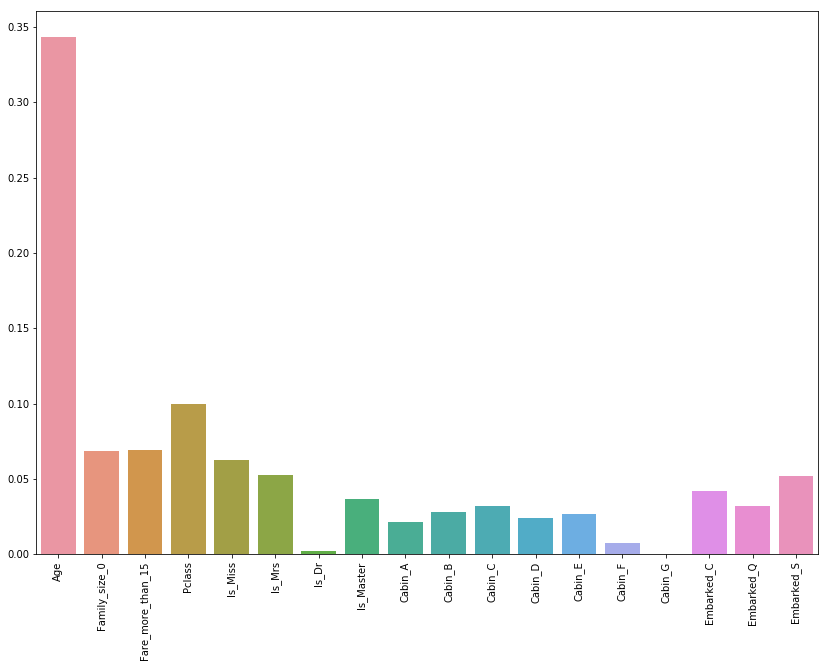

In [94]:
plt.figure(figsize=(14,10))
sns.barplot(x = feature_importance[:,0], y = feature_importance[:,1].astype('float'))
plt.xticks(rotation=90)
plt.show()

- Age looks like really crucial feature..